# Clasificación de Emociones en Tweets con SVM

## 1. Visión General del Proyecto

Este cuaderno implementa una **Máquina de Vectores de Soporte (Linear SVC)** para clasificar el sentimiento/emoción de tweets. El objetivo es procesar texto crudo (limpiando emojis, usuarios y ruido) y entrenar un modelo capaz de distinguir entre emociones complejas.

### 1.1 Descripción del Dataset: WASSA-2017 & CrowdFlower

El dataset utilizado es un subconjunto curado derivado de la **WASSA-2017 Shared Task** (Workshop on Computational Approaches to Subjectivity, Sentiment and Social Media Analysis).

**Estructura y Balance:**
Para evitar sesgos hacia clases mayoritarias, el dataset fue estrictamente balanceado:

* **Emociones:** Miedo (Fear), Tristeza (Sadness), Alegría (Joy), Enojo (Anger).
* **Clase Neutra:** Agregada de **CrowdFlower** para permitir al modelo distinguir contenido no emocional.
* **Tamaño de la Muestra:**
    * *Entrenamiento:* 1,200 tweets por emoción (Total: 6,000).
    * *Prueba:* 150 tweets por emoción (Total: 750).

In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK para procesamiento de lenguaje natural
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Scikit-Learn para modelado
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 100)

# Descarga de recursos NLTK (solo si no existen)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('punkt_tab')

# Inicializar recursos globales
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

## 2. Carga de Datos

Cargamos los conjuntos de datos pre-divididos para garantizar la reproducibilidad.

In [2]:
try:
    # Ajusta la ruta a donde tengas tus archivos csv si es necesario
    train_df = pd.read_csv('../data/wassa_train.csv')
    test_df = pd.read_csv('../data/wassa_test.csv')
    
    print(f"Training Set Loaded: {train_df.shape[0]} tweets.")
    print(f"Test Set Loaded:     {test_df.shape[0]} tweets.")
    
    # Verificación de balance
    print("\nDistribución de clases (Train):")
    print(train_df['emotion'].value_counts())
except FileNotFoundError:
    print("Error: No se encontró el archivo. Verifica la ruta.")

Training Set Loaded: 6000 tweets.
Test Set Loaded:     750 tweets.

Distribución de clases (Train):
emotion
joy        1200
anger      1200
neutral    1200
sadness    1200
fear       1200
Name: count, dtype: int64


## 3. Preprocesamiento y Representación de Texto

Para preparar los datos no estructurados, implementamos un pipeline de limpieza crítico para reducir el ruido.

El proceso consiste en las siguientes etapas:

1.  **Manejo de Emojis:** Convertimos emojis a texto (ej. 🤣 $\rightarrow$ `:rolling_on_the_floor_laughing:`) usando `emoji.demojize`. Esto preserva la información semántica.
2.  **Eliminación de Ruido:** Eliminamos usuarios (`@user`), enlaces (`https://`) y hashtags.
3.  **Normalización Unicode:** Convertimos caracteres especiales a ASCII (ej. acentos) para reducir el tamaño del vocabulario.
4.  **Tokenización y Stemming:** Dividimos el texto y reducimos las palabras a su raíz léxica (ej. "depressed" $\rightarrow$ "depress").

In [3]:
def clean_corpus(text):
    """
    Pipeline de preprocesamiento: Emojis -> Limpieza Regex -> ASCII -> Stemming.
    """
    # 1. Traducir emojis a texto (preserva significado semántico)
    # Usamos delimiters vacíos o espacios para que no se peguen a las palabras
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # 2. Eliminar enlaces, usuarios y hashtags
    # Eliminamos usuarios (@...) y links
    text = re.sub(r'@[^\s]+|https?://\S+', '', text)
    text = re.sub(r'#', '', text) 

    # 3. Normalización Unicode (ASCII)
    # Esto ayuda a estandarizar caracteres especiales
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    
    # 4. Tokenización y limpieza básica (solo letras)
    # Convertimos a minúsculas aquí
    text = text.lower()
    
    # Regex compilado para eficiencia: mantiene solo letras a-z y espacios
    text = re.sub(r'[^a-z\s]+', ' ', text)
    
    # 5. Stopwords y Stemming
    tokens = word_tokenize(text)
    
    filtered_tokens = [
        stemmer.stem(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2 # Filtramos palabras muy cortas
    ]
    
    return ' '.join(filtered_tokens)

# Aplicar limpieza
print("Procesando tweets...")
train_df['cleaned_text'] = train_df['tweet'].apply(clean_corpus)
test_df['cleaned_text'] = test_df['tweet'].apply(clean_corpus)

# Vista previa
display(train_df[['tweet', 'cleaned_text']].sample(5, random_state=42))

Procesando tweets...


,tweet,cleaned_text
1782,@EagleGiles23 @tgilmore_92 what I miss?,miss
3917,Your boy' is having a nightmare @VivaLaSergio,boy nightmar
221,First College Math Test tomorrow,first colleg math test tomorrow
2135,Anger is cheap and politeness is expensive. Don't expect everybody to be polite. #ThoughtfulThur...,anger cheap polit expens expect everybodi polit thoughtfulthursday polit
5224,I was rooting for Betty.,root betti


### 3.1 Vectorización (TF-IDF)

Convertimos el texto limpio en una matriz numérica utilizando **TF-IDF** (Term Frequency - Inverse Document Frequency). Esto penaliza las palabras que aparecen demasiado en todo el corpus (poco informativas) y resalta las específicas de cada tweet.

In [4]:
# Vectorización
vectorizer = TfidfVectorizer(max_features=10000) # Limitamos features para eficiencia
X_train = vectorizer.fit_transform(train_df["cleaned_text"])
X_test = vectorizer.transform(test_df["cleaned_text"])

print(f"Dimensión de la matriz de entrenamiento: {X_train.shape}")

Dimensión de la matriz de entrenamiento: (6000, 8790)


#### Análisis de la Matriz Dispersa
Como regla general, si más de 2/3 de los elementos son ceros, se considera una matriz dispersa.

Examinemos las palabras más relevantes (TF-IDF más alto) para el primer tweet:

In [5]:
# Análisis del primer tweet
feature_names = vectorizer.get_feature_names_out()
first_vector = X_train[0]

df_tfidf = pd.DataFrame(first_vector.T.todense(), index=feature_names, columns=["tfidf"])
df_tfidf = df_tfidf[df_tfidf["tfidf"] > 0].sort_values("tfidf", ascending=False)

print(f"Tweet Original: {train_df.iloc[0]['tweet']}")
print(f"Tweet Procesado: {train_df.iloc[0]['cleaned_text']}")
print("\nPalabras Clave (TF-IDF):")
print(df_tfidf)

Tweet Original: Kinda wished I watched mischievous kiss before playful kiss
Tweet Procesado: kinda wish watch mischiev kiss play kiss

Palabras Clave (TF-IDF):
             tfidf
kiss      0.694938
mischiev  0.455764
kinda     0.344577
wish      0.276579
play      0.248155
watch     0.229194


### Discusión: TF vs IDF
*Respuesta del estudiante:*

**Sobre la palabra 'watch' (TF-IDF bajo):**
TF = 1/7 = 0.14. TF-IDF = TF * IDF -> 0.22. Es una palabra no tan común, por lo tanto es difícil otorgarle un grado relevante de significancia.

**Sobre la palabra 'kiss' (TF-IDF alto):**
TF = 2/7 = 0.28. IDF calculado aprox 2.6. Al ser una palabra con mayor frecuencia de uso en este contexto específico (aparece dos veces en un tweet corto), adquiere mayor peso.

## 4. Codificación de Etiquetas

Convertimos las etiquetas categóricas (`joy`, `sadness`, etc.) a valores numéricos.

In [6]:
label_encoder = LabelEncoder()
# Definimos el orden explícitamente si deseamos, o dejamos que fit lo haga alfabéticamente
y_train_encoded = label_encoder.fit_transform(train_df["emotion"])
y_test_encoded = label_encoder.transform(test_df["emotion"])

# Mapeo resultante
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de Clases:", class_mapping)

Mapeo de Clases: {'anger': 0, 'fear': 1, 'joy': 2, 'neutral': 3, 'sadness': 4}


## 5. Entrenamiento del Modelo SVM

Utilizamos una función modular para entrenar y evaluar, facilitando la reutilización del código.

Los mejores hiperparámetros encontrados en la literatura y experimentación previa fueron: `C=10`, `gamma=1`, `kernel='rbf'`.

Entrenando modelo con 6000 muestras...

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

       anger       0.89      0.89      0.89       150
        fear       0.87      0.83      0.85       150
         joy       0.92      0.87      0.89       150
     neutral       0.74      0.82      0.78       150
     sadness       0.89      0.87      0.88       150

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750



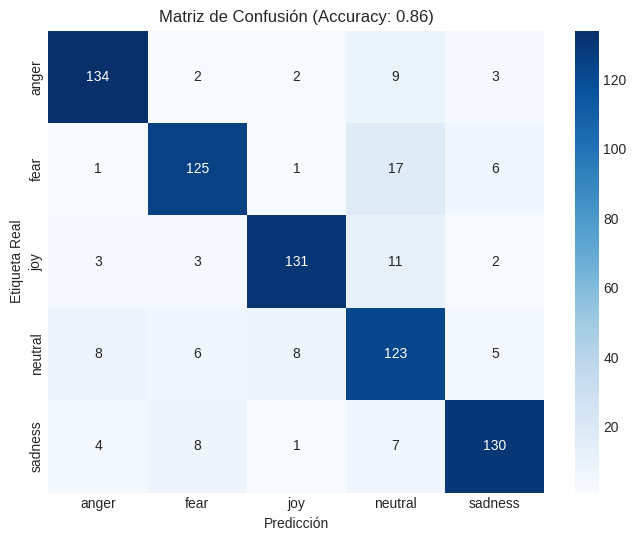

In [7]:
def train_evaluate_model(X_train, y_train, X_test, y_test, classes):
    """
    Entrena un SVM y muestra reporte de clasificación y matriz de confusión.
    """
    # 1. Configuración del modelo (Mejores parámetros)
    svm = SVC(C=10, gamma=1, kernel='rbf')
    
    # 2. Entrenamiento
    print(f"Entrenando modelo con {X_train.shape[0]} muestras...")
    svm.fit(X_train, y_train)
    
    # 3. Predicción
    y_pred = svm.predict(X_test)
    
    # 4. Métricas
    print("\n--- Reporte de Clasificación ---")
    print(classification_report(y_test, y_pred, target_names=classes))
    
    acc = accuracy_score(y_test, y_pred)
    
    # 5. Visualización
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de Confusión (Accuracy: {acc:.2f})')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción')
    plt.show()
    
    return svm, y_pred

# Ejecutar entrenamiento principal
model_v1, predictions_v1 = train_evaluate_model(
    X_train, y_train_encoded, 
    X_test, y_test_encoded, 
    label_encoder.classes_
)

### Discusión: Kernel RBF
*Respuesta del estudiante:*

**¿Por qué el kernel RBF tuvo mayor exactitud?**
Por su adaptabilidad respecto a la gama de datos, gracias a su valor por default `gamma` y su capacidad de trazar fronteras de decisión no lineales.

**Análisis de Hiperparámetros (C y Gamma):**
Una configuración de `C=0.01` y `gamma=10` produce un accuracy bajo (0.26) debido al **sobreajuste (overfitting)** severo o underfitting (dependiendo del caso extremo), donde el modelo no generaliza nada. Los parámetros `C=10` y `gamma=1` funcionan mejor porque los márgenes tienen una restricción balanceada.

---

## 6. Ejercicio: Eliminando la Clase 'Neutral'

El objetivo de la etiqueta neutral es evitar clasificar emociones desconocidas forzosamente. En este ejercicio, simulamos un escenario donde solo existen las 4 emociones básicas.

Filtrar el dataset y re-entrenar:

Train sin neutrales: (4800, 4)
Test sin neutrales:  (600, 4)
Entrenando modelo con 4800 muestras...

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

       anger       0.92      0.93      0.93       150
        fear       0.88      0.91      0.90       150
         joy       0.96      0.90      0.93       150
     sadness       0.89      0.89      0.89       150

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



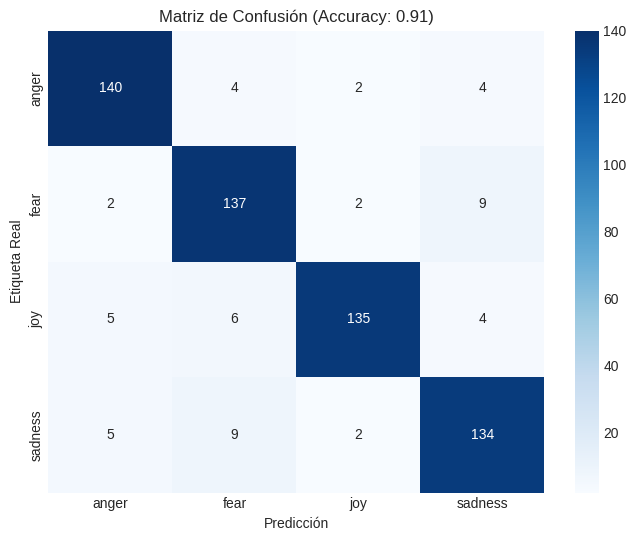

In [8]:
# 1. Filtrar DataFrames
train_df_no_neu = train_df[train_df['emotion'] != 'neutral'].copy()
test_df_no_neu = test_df[test_df['emotion'] != 'neutral'].copy()

print(f"Train sin neutrales: {train_df_no_neu.shape}")
print(f"Test sin neutrales:  {test_df_no_neu.shape}")

# 2. Re-codificar etiquetas (Importante: el encoder anterior tenía 5 clases)
le_no_neu = LabelEncoder()
y_train_no_neu = le_no_neu.fit_transform(train_df_no_neu['emotion'])
y_test_no_neu = le_no_neu.transform(test_df_no_neu['emotion'])

# 3. Vectorizar (Ajustamos el vectorizador al nuevo corpus filtrado)
vect_no_neu = TfidfVectorizer(max_features=10000)
X_train_no_neu = vect_no_neu.fit_transform(train_df_no_neu['cleaned_text'])
X_test_no_neu = vect_no_neu.transform(test_df_no_neu['cleaned_text'])

# 4. Entrenar y Evaluar usando nuestra función
model_v2, predictions_v2 = train_evaluate_model(
    X_train_no_neu, y_train_no_neu,
    X_test_no_neu, y_test_no_neu,
    le_no_neu.classes_
)

### Análisis de Errores (Misclassification)

Analizamos tweets que el modelo clasificó incorrectamente o situaciones donde la etiqueta original podría ser debatible.

*Respuesta del estudiante sobre etiquetas dudosas:*

1.  **Anger (Enojo):** Un tweet recomendando un libro ("reading prisoners of hate") fue etiquetado como *anger*. Está mal porque es una simple recomendación.
2.  **Fear (Miedo):** Un tweet sobre una discusión con la alarma del reloj. No expresa miedo real, solo molestia por levantarse.
3.  **Joy (Alegría):** "Anyone who drinks sparkling water is a demon". Etiquetado como *joy*, pero es sarcasmo u opinión, no alegría genuina.
4.  **Sadness (Tristeza):** "Life's too short to be frowning". Es una frase motivacional, no de tristeza.

### Conclusión Final

**¿Deberíamos mantener la clase Neutral?**
*Respuesta:* Depende del contexto. Aunque quitarla mejora la exactitud numérica (al reducir la complejidad del problema), en un entorno real **la quitaría o la redefiniría**, pero reconociendo que no existe un mundo ideal de solo cuatro emociones. Es necesario categorizar el "ruido" o la falta de emoción para no forzar predicciones erróneas.